# Softmax exercise

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

Credit: [cs231n.stanford.edu](http://cs231n.stanford.edu)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
sys.path.append("/content/gdrive/My Drive/Colab Notebooks/backpropagation_workshop")

import random
import numpy as np
#from cs231n.data_utils import load_CIFAR10
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [0]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.
    """
    # Load the raw CIFAR-10 data
    #cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    cifar10_dir = '/content/gdrive/My Drive/Colab Notebooks/backpropagation_workshop/cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py** and **cs231n/classifiers/linear_classifier.py**

### Subtask 1
First implement the naive softmax loss function with nested loops.
Open the file cs231n/classifiers/softmax.py and implement the
softmax_loss_naive function.

In [0]:
from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.350325
sanity check: 2.302585


**Inline Question (1 point)**:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.

**Your answer:** *Fill this in* Answer: because our W matrix is random and hence entropy will be maximal. Entropy is maximal when uncertainty is maximal. Uncertainty is maximal when all probabilities are equal. For this case they are 1/10. And -np.log(0.1) is just an arithmetical mean.


### Subtask 2 (1 point)
Complete the implementation of softmax_loss_naive and implement a (naive)
version of the gradient that _uses nested loops_.



In [0]:
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.909555 analytic: 0.909555, relative error: 9.242586e-08
numerical: 3.539813 analytic: 3.539813, relative error: 9.819362e-09
numerical: -2.129854 analytic: -2.129854, relative error: 2.254169e-08
numerical: 0.464625 analytic: 0.464625, relative error: 1.427654e-07
numerical: -1.125533 analytic: -1.125533, relative error: 3.180122e-08
numerical: 1.157714 analytic: 1.157714, relative error: 4.583505e-08
numerical: 1.362571 analytic: 1.362571, relative error: 2.144475e-10
numerical: -0.543652 analytic: -0.543652, relative error: 1.244407e-07
numerical: 0.178640 analytic: 0.178640, relative error: 1.532561e-07
numerical: 3.539813 analytic: 3.539813, relative error: 9.819362e-09
numerical: 2.033862 analytic: 2.033862, relative error: 2.511466e-08
numerical: -0.711246 analytic: -0.711247, relative error: 3.306055e-08
numerical: -0.338504 analytic: -0.338505, relative error: 9.777238e-08
numerical: -1.209655 analytic: -1.209655, relative error: 4.433181e-08
numerical: -1.183307 a

### Subtask 3 (4 points)

Now that we have a naive implementation of the softmax loss function and its gradient,
implement a vectorized version in softmax_loss_vectorized.
The two versions should compute the same results, but the vectorized version should be
much faster.

In [0]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.350325e+00 computed in 0.151793s
vectorized loss: 2.350325e+00 computed in 0.013735s
Loss difference: 0.000000
Gradient difference: 0.000000


### Subtask 4 (2 points)

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [0]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
model = Softmax()
tic = time.time()
loss_hist = model.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                        num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 388.803732
iteration 100 / 1500: loss 235.335484
iteration 200 / 1500: loss 143.077791
iteration 300 / 1500: loss 87.299353
iteration 400 / 1500: loss 53.569584
iteration 500 / 1500: loss 33.132329
iteration 600 / 1500: loss 20.912082
iteration 700 / 1500: loss 13.449694
iteration 800 / 1500: loss 8.926871
iteration 900 / 1500: loss 6.148368
iteration 1000 / 1500: loss 4.569675
iteration 1100 / 1500: loss 3.579861
iteration 1200 / 1500: loss 2.969077
iteration 1300 / 1500: loss 2.591153
iteration 1400 / 1500: loss 2.278291
That took 10.784767s


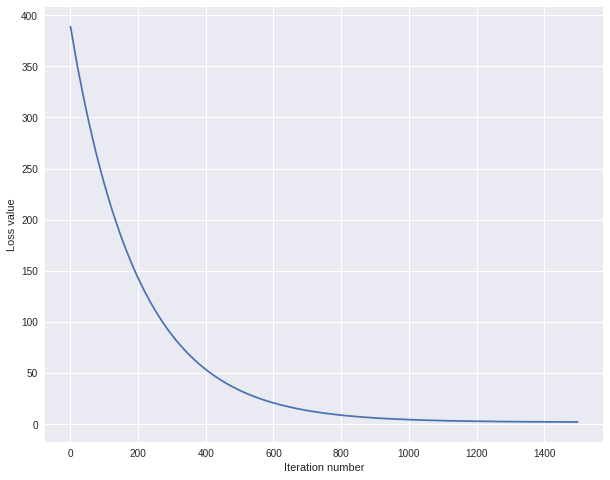

In [0]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [0]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = model.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = model.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.349878
validation accuracy: 0.356000


### Subtask 5 (2 points)

Use the validation set to tune hyperparameters (regularization strength and
learning rate). You should experiment with different ranges for the learning
rates and regularization strengths; if you are careful you should be able to
get a classification accuracy of over 0.35 on the validation set.

In [0]:
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1       # The highest validation accuracy that we have seen so far.
best_softmax = None # The Softmax object that achieved the highest validation rate.
learning_rates = np.logspace(-10, 10, 10)
regularization_strengths = np.logspace(-3, 6, 10)

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a Softmax clf on the     #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the Softmax object that achieves this    #
# accuracy in best_softmax.                                                    #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the Softmax don't take much time to train; once you  #
# are confident that your validation code works, you should rerun the          #
# validation code with a larger value for num_iters.                           #
################################################################################
iters = 100
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=iters)
        
        y_train_pred = softmax.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (acc_train, acc_val)
        
        if best_val < acc_val:
            best_val = acc_val
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

/content/gdrive/My Drive/Colab Notebooks/backpropagation_workshop/cs231n/classifiers/softmax.py:86: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(softmax[np.arange(num_train), y]))
/content/gdrive/My Drive/Colab Notebooks/backpropagation_workshop/cs231n/classifiers/softmax.py:93: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(np.power(W, 2))
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/content/gdrive/My Drive/Colab Notebooks/backpropagation_workshop/cs231n/classifiers/softmax.py:93: RuntimeWarning: overflow encountered in power
  loss += 0.5 * reg * np.sum(np.power(W, 2))
/content/gdrive/My Drive/Colab Notebooks/backpropagation_workshop/cs231n/classifiers/softmax.py:82: RuntimeWarning: overflow encountered in subtract
  f -= np.max(f, axis=1, keepdims=True) # max of every sample
/content/gdrive/My Drive/Col

lr 1.000000e-10 reg 1.000000e-03 train accuracy: 0.104510 val accuracy: 0.099000
lr 1.000000e-10 reg 1.000000e-02 train accuracy: 0.095449 val accuracy: 0.104000
lr 1.000000e-10 reg 1.000000e-01 train accuracy: 0.108061 val accuracy: 0.115000
lr 1.000000e-10 reg 1.000000e+00 train accuracy: 0.086122 val accuracy: 0.100000
lr 1.000000e-10 reg 1.000000e+01 train accuracy: 0.116306 val accuracy: 0.121000
lr 1.000000e-10 reg 1.000000e+02 train accuracy: 0.091490 val accuracy: 0.086000
lr 1.000000e-10 reg 1.000000e+03 train accuracy: 0.114837 val accuracy: 0.117000
lr 1.000000e-10 reg 1.000000e+04 train accuracy: 0.081041 val accuracy: 0.066000
lr 1.000000e-10 reg 1.000000e+05 train accuracy: 0.099531 val accuracy: 0.108000
lr 1.000000e-10 reg 1.000000e+06 train accuracy: 0.089551 val accuracy: 0.097000
lr 1.668101e-08 reg 1.000000e-03 train accuracy: 0.094837 val accuracy: 0.092000
lr 1.668101e-08 reg 1.000000e-02 train accuracy: 0.106510 val accuracy: 0.116000
lr 1.668101e-08 reg 1.000000

In [0]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.356000


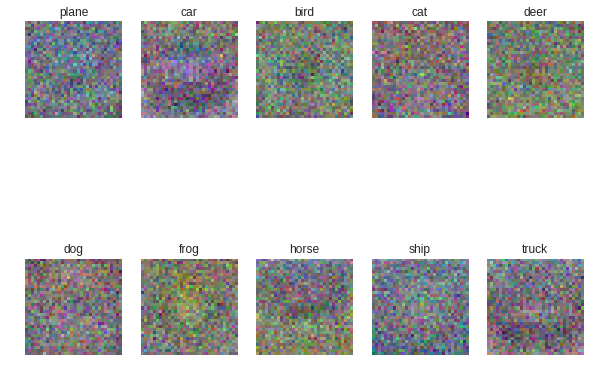

In [0]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

#### Max score: 10 points